# 📝 LSTM 프로젝트: 멋진 작사가 만들기

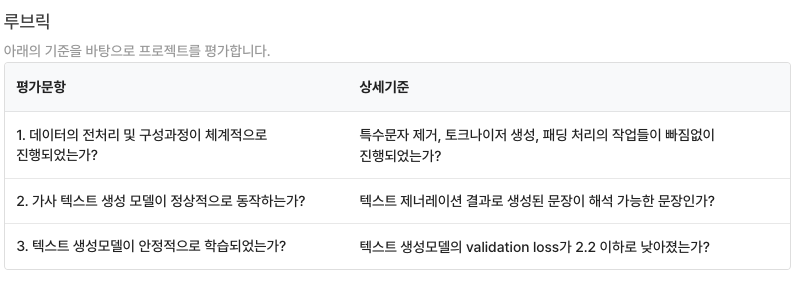

In [3]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow

print(tensorflow.__version__)

2.11.0


# Step 1. 데이터 준비하기

데이터는 aiffel data에서 로컬로 다운로드 받아서 불러왔다.

오래 코드는 aiffel에 있던 모든 가사 파일을 하나의 압축 파일로 만들어 주는 코드이다.

In [4]:
# LMS 다운로드
# lyrics =os.listdir(os.getenv('HOME') + '/aiffel/lyricist/data/lyrics')

# import zipfile

# with zipfile.ZipFile("lyrics.zip", mode="a") as archive:
#     for i in lyrics:
#         archive.write(os.getenv('HOME') + '/aiffel/lyricist/data/lyrics/'+i)

# Step 2. 데이터 읽어오기

glob을 이용해서 찾고자하는 파일들을 모두 불러와, corpus로 저장해보자.

In [19]:
txt_file_path = '/Users/seungyonglee/Desktop/Life3/aiffel/project/data/lyrics'

txt_list = glob.glob(txt_file_path + '/*.txt') #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당
raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', 'All of this and more is for you']


말뭉치(corpus)에 어떤 내용이 들어갔는지 확인하기 위해 첫번째 파일만 여러보자.

In [20]:
with open(txt_list[0]) as f :
    lyric = f.read()
    
print(lyric)



All of this and more is for you
With love, sincerity and deepest care
My life with you I share


Ever since I met you, baby
I've been wantin' to lay you down
But it's so hard to get you
Baby, when you never come around
Every day that you keep it away
It only makes me want it more
Ooh baby, just say the word
And I'll be at your door

What more do I have to say?
I really wanna play in your river

Fallin', fallin', fallin' in love
I'm fallin', baby, deeper every day
(In love)
You're breakin' my heart and takin' me away
(In love)
I'm fallin' baby, girl, what can I do?
I just can't be without you

Ever since I met you, baby
There's been somethin' inside of me
That keeps me wantin' you
Baby, won't you set me free?
Take off these chains, girl
And I'll take off yours
There's no one in the world, baby
That I wanna love more

What else do I have to say?
I really wanna play in your river

Fallin', fallin', fallin' in love
I'm fallin' baby, deeper every day
(In love)
You're breakin' my heart and

# Step 3. 데이터 정제

In [21]:
import re

먼저 컴퓨터가 문자를 이해하기 위해서는 컴퓨터가 이해할 수 있는 언어로 문자들을 변환해주어야한다.

컴퓨터는 자연어의 의미를 이해를 못한다, 그러나 embedding을 통해서는 우리가 이해하는 수준에서의 의미 부여를 해줄수는 없지만,

단어들마다 가중치와 bias등을 주어서 숫자적으로 특징들을 줄 수 있다.

그 작얼을 진행해볼 것이다.

컴퓨터는 문장의 시작과 끝을 알수 없고, 대문자와 소문자를 따로 구분하고, 특수문자도 별도의 문자로 인식하기 때문에 이 부분도 처리해주어야한다.

In [22]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1. 소문자로 변환
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2. 특수문자 빈칸으로 변환
    sentence = re.sub(r'[" "]+', " ", sentence) # 3 여러개의 공백은 하나의 공백으로 바꿉니다
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4 a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
    sentence = sentence.strip() # 5. 다시 양쪽 공백을 지웁니다
    sentence = '<start> ' + sentence + ' <end>' # 6 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


이제 위에 방식을 이용하여 raw corpus를 전처리해보자.

In [27]:
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if len(sentence) > 30: continue #길이가 너무 길면 모델링에 문제가 생길 가능성이 높다
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> my life with you i share <end>',
 '<start> ever since i met you , baby <end>',
 '<start> but it s so hard to get you <end>',
 '<start> it only makes me want it more <end>',
 '<start> ooh baby , just say the word <end>',
 '<start> and i ll be at your door <end>',
 '<start> what more do i have to say ? <end>',
 '<start> in love <end>',
 '<start> in love <end>',
 '<start> i just can t be without you <end>']

위에 10개의 줄을 확인한 결과, 각 가사의 줄의 시작과 끝을 추가하였고, 전처리과정이 잘 수행이 되었다.

In [28]:
import tensorflow as tf

이제 모델링에 들어가기 전에 또 필수적인 단계가 있다.

바로 tokenizing단계다. tokenizing은 텍스트 데이터에 대한 정보를 단위별로 나누어, 컴퓨터가 문자를 연산할 수 있는 숫자로 변환해주는 단계이다.

이번 프로젝트에서는 각 가사 줄을 단어 단위로 쪼개서 분석할 것이다. 따라서, tokenization은 문자마다 숫자를 부여해줄 것이다.

unique한 단어는 7000천자로 구분하고 이 단어에 포함되지 않은 것은 \<unk>으로 처리할 예정이다

tokenize는 tensorflow에 Tokenizer를 사용한다.

https://www.tokenex.com/blog/ab-what-is-nlp-natural-language-processing-tokenization/
https://velog.io/@dayday/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-Tokenizing

In [29]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2  13 104 ...   0   0   0]
 [  2 182 532 ...   0   0   0]
 [  2  44  11 ...   0   0   0]
 ...
 [  2  25  25 ...   0   0   0]
 [  2   4  21 ...   0   0   0]
 [  2  25  25 ...   0   0   0]] <keras.preprocessing.text.Tokenizer object at 0x7fad879bd880>


각 가사 줄들이 숫자로 변환된 것을 확인할 수 있다. 생성된 데이터 3번째 행, 10번째 열까지만 출력해 보자.

In [30]:
tensor.shape

(72847, 20)

In [31]:
print(tensor[:3, :10])

[[  2  13 104  47   6   4 989   3   0   0]
 [  2 182 532   4 502   6   5  42   3   0]
 [  2  44  11  17  28 201  10  45   6   3]]


위 내용은 아래 가사를 숫자로 표현한 것이다

In [32]:
corpus[:3]

['<start> my life with you i share <end>',
 '<start> ever since i met you , baby <end>',
 '<start> but it s so hard to get you <end>']

밑에 단어 사전을 불러와서 보면 <start>는 2 <end>는 3인 것을 확인할 수 있다.
    
0은 sequence의 길이를 맞추기 위해 채워진 값이다.
    
위에 tokenizer에 fit된 corpus를 index_word 속성을 이용하면 단어 사전을 순서대로 반환한다.

In [33]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : you
7 : the
8 : and
9 : a
10 : to


In [34]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2  13 104  47   6   4 989   3   0   0   0   0   0   0   0   0   0   0
   0]
[ 13 104  47   6   4 989   3   0   0   0   0   0   0   0   0   0   0   0
   0]


마지막으로 우리는 데이터셋 객체를 생성할 것입니다.

텐서로 생성된 데이터를 이용해 tf.data.Dataset객체를 생성한다.

tf.data.Dataset객체는 텐서플로우에서 사용할 경우 데이터 입력 파이프라인을 통한 속도 개선 및 각종 편의 기능을 제공한다.

우리는 이미 데이터셋을 텐서 형태로 생성해 두었으므로, 
tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성할 것이다.

# Step 4. 평가 데이터셋 분리

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# train : test = 8: 2로 분리
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input,
                                                   test_size=0.2,
                                                   random_state=1)

In [37]:
print(f"enc_train size : {len(enc_train):>6}")
print(f"enc_val size   : {len(enc_val):>6}")
print(f"dec_train size : {len(dec_train):>6}")
print(f"dec_val size   : {len(dec_val):>6}")

enc_train size :  58277
enc_val size   :  14570
dec_train size :  58277
dec_val size   :  14570


In [49]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

In [50]:
 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 7000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 19), dtype=tf.int32, name=None), TensorSpec(shape=(256, 19), dtype=tf.int32, name=None))>

위에 방식으로 전처리 과정은 끝났다.

이제 모델을 학습하는 단계로 넘어가자.

만들 모델에는 1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.

각 구조에 대한 설명은 여기서는 하지 않겠다.

In [101]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 256 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

In [102]:
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 19, 12001), dtype=float32, numpy=
array([[[ 1.90898063e-05,  7.94257576e-05,  3.07911650e-05, ...,
         -7.23026824e-05, -1.49061932e-04, -1.97910325e-04],
        [-4.76957939e-05,  1.01233658e-04,  3.21778411e-04, ...,
         -1.91965883e-04, -4.05787359e-05, -1.23262784e-04],
        [-2.21050548e-04, -7.66029116e-05,  6.25315530e-04, ...,
         -2.98822211e-04,  1.01319456e-05,  9.77274613e-06],
        ...,
        [-3.77633754e-04,  2.38104863e-03,  2.51768681e-04, ...,
          2.13543361e-04,  9.53345210e-04,  2.27952376e-03],
        [-3.39219405e-04,  2.62193708e-03,  1.13240443e-04, ...,
          2.72101461e-04,  1.09979743e-03,  2.48015905e-03],
        [-2.83022469e-04,  2.82221357e-03, -8.23009759e-06, ...,
          3.32994270e-04,  1.24441972e-03,  2.66481098e-03]],

       [[ 1.90898063e-05,  7.94257576e-05,  3.07911650e-05, ...,
         -7.23026824e-05, -1.49061932e-04, -1.97910325e-04],
        [ 1.05621555e-04,  1.15997260e-04, -4

In [103]:
# 모델의 구조를 확인합니다.
model.summary()

Model: "text_generator_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  3072256   
                                                                 
 lstm_4 (LSTM)               multiple                  5246976   
                                                                 
 lstm_5 (LSTM)               multiple                  8392704   
                                                                 
 dense_2 (Dense)             multiple                  12301025  
                                                                 
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


# Step 5. 인공지능 만들기

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [46]:
# tf.config.list_physical_devices('GPU')

아래 모델 학습은 GPU가 없어서 aiffel cloud환경에서 진행하고 모델을 저장하여 사용하였다.

In [47]:
# # Reduce learning rate
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
#                                             patience=2,
#                                             verbose=1,
#                                             factor=0.5,
#                                             min_lr=0.0003)

# # EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

# optimizer = tf.keras.optimizers.Adam()

# loss = tf.keras.losses.SparseCategoricalCrossentropy( 
#     from_logits=True, reduction='none') # 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값),그렇지 않으면 from_logits = True.

# model.compile(loss=loss, optimizer=optimizer)

# #earlystop 및 learning_reduction은 주완님 작업 부분을 참고하였다.
# history_1st = model.fit(dataset, epochs=30, validation_data=(enc_val, dec_val), callbacks=[learning_rate_reduction, early_stop])

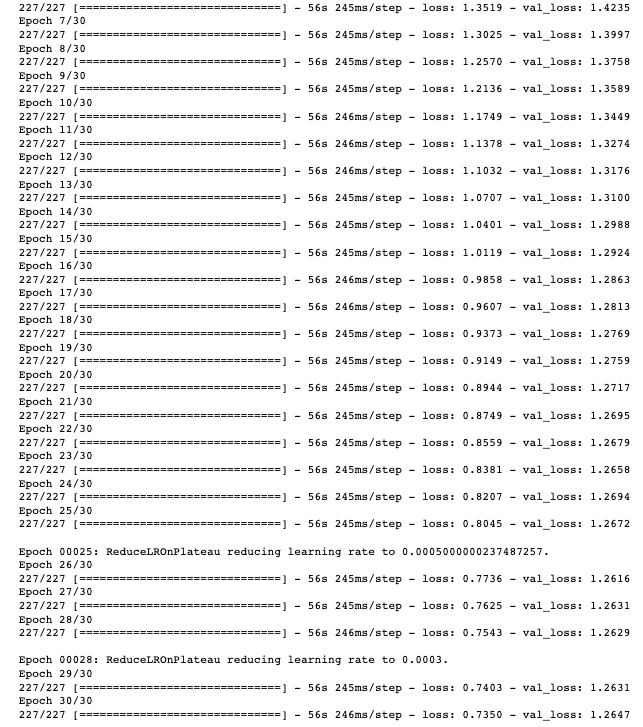

In [106]:
#lms에서 학습한 모델을 로컬에서 불러온다
newmodel = tf.keras.models.load_model('/Users/seungyonglee/Desktop/Life3/aiffel/project/data/lyrics/model')

In [125]:
model.set_weights(newmodel.get_weights()) #기존 모델에 불러온 모델의 가중치 적용

In [126]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

가사를 작성해보자.
아래 내용을 넣어 가사를 생성하자 :

**verse**
1. you love
2. life
3. baby
    
**chorus**

4. beautiful
5. because
6. need you
7. baby

**bridge**

8. love
9. bye
10. baby

In [140]:
generate_text(model, tokenizer, init_sentence="<start> you love", max_len=20)

'<start> you love me when i aint rhythm <end> '

In [130]:
generate_text(model, tokenizer, init_sentence="life", max_len=20)

'life i feel it <end> '

In [131]:
generate_text(model, tokenizer, init_sentence="baby", max_len=20)

'baby i m not here <end> '

In [132]:
#chorus
generate_text(model, tokenizer, init_sentence="beauty", max_len=20)

'beauty i m a bitch <end> '

In [133]:
generate_text(model, tokenizer, init_sentence="because", max_len=20)

'because and i m a go hard go <end> '

In [134]:
generate_text(model, tokenizer, init_sentence="need you", max_len=20)

'need you know i love you <end> '

In [135]:
generate_text(model, tokenizer, init_sentence="baby", max_len=20)

'baby i m not here <end> '

In [137]:
generate_text(model, tokenizer, init_sentence=" love ", max_len=20)

'love <end> '

In [138]:
#outro
generate_text(model, tokenizer, init_sentence="bye", max_len=20)

'bye santo fact fact fact fact fact fact fact fact fact fact fact fact fact fact fact fact fact fact '

In [139]:
generate_text(model, tokenizer, init_sentence="baby", max_len=20)

'baby i m not here <end> '

#### Song by AI :

Verse :</br>
'you love me when i aint rhythm'</br>
'life i feel it '</br>
'baby i m not here '</br>
</br>
Chorus :</br>
'beauty i m a bitch '</br>
'because and i m a go hard go '</br>
'need you know i love you'</br>
'baby i m not here'</br>
</br>
Bridge :</br>
'love'</br>
'bye santo fact fact fact fact fact fact fact fact fact fact fact fact fact fact fact fact fact fact '</br>
'baby i m not here '</br>


### 회고

LSTM을 이용해서 가사 생성기(?)를 만들었다.

**modeling and preprocessing**

프로젝트를 진행할때 코드 구현에 집중하는 편이다.

이번에는 tf로 임베딩을 하였는데 다양한 방식으로도 할 수 있는 것을 알고 있다.

자연어처리에서 전처리 과정에 보다 많은 시간을 투자해서, 

다양한 임베딩 방법과 자연어 모델들에 대해 보다 깊게 공부할 필요가 있을 것 같다.

**GPU**

이번 프로젝트에서는 GPU의 필요성을 더 크게 느꼈다...

로컬에서는 아무리 돌릴려고 시도해도, CPU로 연산 처리하게 되면 물리적으로 프로젝트 마무리가 불가능하다는 것을 느꼈다.

너무 오랜 시간이 걸려 어쩔 수 없이 LMS GPU힘을 빌리게 되었다.

앞으로 모델들이 무거워지면 현재 사용하고 있는 로컬 환경에서는 무리가 있지 않을까 생각이 든다.

이 상황을 피하기 위해서는 사전에 lms와 비슷한 다른 클라우드 환경도 찾아보는 것도 좋을 것 같다.

Hugging Face?